## What is: Jeopardy Value Predictions?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [4]:
from textblob import TextBlob
from wordcloud import WordCloud

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [6]:
df = pd.read_csv("combined_season1-37.tsv.zip", delimiter='\t')

In [7]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,100,no,LAKES & RIVERS,-,River mentioned most often in the Bible,the Jordan,1984-09-10,-
1,1,200,no,LAKES & RIVERS,-,Scottish word for lake,loch,1984-09-10,-
2,1,800,yes,LAKES & RIVERS,-,River in this famous song:,the Volga River,1984-09-10,-
3,1,400,no,LAKES & RIVERS,-,American river only 33 miles shorter than the ...,the Missouri,1984-09-10,-
4,1,500,no,LAKES & RIVERS,-,"World's largest lake, nearly 5 times as big as...",the Caspian Sea,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389440,2,400,no,FOUNDRY,-,This hefty noisemaker from Whitechapel Foundry...,Big Ben,2021-08-13,-
389441,2,800,no,FOUNDRY,-,"Around 4,000 years ago, the first foundries in...",bronze,2021-08-13,-
389442,2,1200,no,FOUNDRY,-,Several different foundries worked for 4 month...,Monitor,2021-08-13,-
389443,2,1600,no,FOUNDRY,-,"Once one of the largest of its kind, the Gary ...",U.S. Steel,2021-08-13,-


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389445 entries, 0 to 389444
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   round         389445 non-null  int64 
 1   value         389445 non-null  int64 
 2   daily_double  389445 non-null  object
 3   category      389445 non-null  object
 4   comments      389445 non-null  object
 5   answer        389445 non-null  object
 6   question      389445 non-null  object
 7   air_date      389445 non-null  object
 8   notes         389445 non-null  object
dtypes: int64(2), object(7)
memory usage: 26.7+ MB


In [9]:
df.isna().sum()

round           0
value           0
daily_double    0
category        0
comments        0
answer          0
question        0
air_date        0
notes           0
dtype: int64

In [10]:
df['air_date'].sort_values()

0         1984-09-10
26        1984-09-10
27        1984-09-10
28        1984-09-10
29        1984-09-10
             ...    
389410    2021-08-13
389411    2021-08-13
389412    2021-08-13
389414    2021-08-13
389444    2021-08-13
Name: air_date, Length: 389445, dtype: object

In [11]:
df['category'].nunique()

47752

In [12]:
df['category'].value_counts().loc[lambda x : x>500] 

SCIENCE                    966
AMERICAN HISTORY           897
LITERATURE                 858
POTPOURRI                  790
HISTORY                    786
WORD ORIGINS               713
BEFORE & AFTER             710
SPORTS                     705
WORLD HISTORY              671
WORLD GEOGRAPHY            657
BUSINESS & INDUSTRY        607
TRANSPORTATION             607
U.S. CITIES                603
RELIGION                   571
COLLEGES & UNIVERSITIES    562
ART                        554
ANIMALS                    544
BODIES OF WATER            535
WORLD CAPITALS             529
U.S. GEOGRAPHY             522
BOOKS & AUTHORS            520
AUTHORS                    514
U.S. HISTORY               512
ISLANDS                    505
Name: category, dtype: int64

In [13]:
df['question'].value_counts().loc[lambda x : x>200] 

Australia       355
Chicago         349
China           343
France          328
Japan           319
India           301
California      301
Spain           298
Canada          284
Alaska          277
Mexico          271
Texas           253
Florida         252
Italy           246
Hawaii          242
Brazil          241
Paris           237
Russia          232
South Africa    230
New York        230
Ireland         223
Germany         221
Egypt           219
Greece          217
Boston          217
New Orleans     214
Sweden          213
London          212
Name: question, dtype: int64

In [14]:
df.groupby('round')['category'].nunique()

round
1    26203
2    24994
3     3082
Name: category, dtype: int64

In [15]:
df.groupby('round')['category'].value_counts()

round  category           
1      SPORTS                 551
       POTPOURRI              497
       AMERICAN HISTORY       409
       ANIMALS                378
       SCIENCE                369
                             ... 
3      \'90s MOVIES             1
       \'90s NONFICTION         1
       \'90s NOTABLES           1
       \'90s OLYMPIC NAMES      1
       \'90s TRENDS             1
Name: category, Length: 54279, dtype: int64

In [16]:
df['value'].value_counts().loc[lambda x : x>90] 

400     75835
800     60242
200     51791
1000    38834
600     36751
2000    26217
1200    23900
1600    22646
100     13116
500     12714
300     12460
0        6647
3000     1684
1500      821
4000      783
5000      511
2500      409
1400      391
1800      331
2200      264
700       259
2400      242
6000      181
2600      175
2800      143
3200      134
900       133
3500      115
1300      107
3400      107
3600      106
Name: value, dtype: int64

In [17]:
df['air_date'] = pd.to_datetime(df['air_date'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389445 entries, 0 to 389444
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   round         389445 non-null  int64         
 1   value         389445 non-null  int64         
 2   daily_double  389445 non-null  object        
 3   category      389445 non-null  object        
 4   comments      389445 non-null  object        
 5   answer        389445 non-null  object        
 6   question      389445 non-null  object        
 7   air_date      389445 non-null  datetime64[ns]
 8   notes         389445 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 26.7+ MB


In [19]:
#On 11/26/2001, the values for the questions doubled for both rounds of Jeopardy. Need to adjust the earlier episodes to have the same values as post-11/26/2001 shows.
df.loc[df['air_date'] < '2001-11-26', "value"] = df.value * 2

In [20]:
df['value'].value_counts()

400     77067
800     73485
200     39138
1000    38857
2000    38205
        ...  
3024        1
8917        1
9066        1
367         1
2814        1
Name: value, Length: 217, dtype: int64

In [21]:
#remove Daily Doubles since the contestants can wager any amounts for those
df = df[df["daily_double"] != 'yes']

In [22]:
df['value'].value_counts()

400     76866
800     73024
200     39048
600     37009
1000    35736
1200    34668
2000    34304
1600    33110
0        6647
2547        1
4000        1
3200        1
2400        1
Name: value, dtype: int64

In [23]:
#keep only standard values (this will remove Final Jeopardy questions, which do not have a set amount and set are at '0', as well as the handful of non-standard values that are likely typos)
df = df.loc[df['value'].isin([200, 400, 600, 800, 1000, 400, 800, 1200, 1600, 2000])]

In [24]:
df['value'].value_counts()

400     76866
800     73024
200     39048
600     37009
1000    35736
1200    34668
2000    34304
1600    33110
Name: value, dtype: int64

In [25]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,200,no,LAKES & RIVERS,-,River mentioned most often in the Bible,the Jordan,1984-09-10,-
1,1,400,no,LAKES & RIVERS,-,Scottish word for lake,loch,1984-09-10,-
3,1,800,no,LAKES & RIVERS,-,American river only 33 miles shorter than the ...,the Missouri,1984-09-10,-
4,1,1000,no,LAKES & RIVERS,-,"World's largest lake, nearly 5 times as big as...",the Caspian Sea,1984-09-10,-
5,1,200,no,INVENTIONS,-,Marconi's wonderful wireless,the radio,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,LOST,-,"In ""A Moveable Feast"", Gertrude Stein is quote...",Lost Generation,2021-08-13,-
389440,2,400,no,FOUNDRY,-,This hefty noisemaker from Whitechapel Foundry...,Big Ben,2021-08-13,-
389441,2,800,no,FOUNDRY,-,"Around 4,000 years ago, the first foundries in...",bronze,2021-08-13,-
389442,2,1200,no,FOUNDRY,-,Several different foundries worked for 4 month...,Monitor,2021-08-13,-


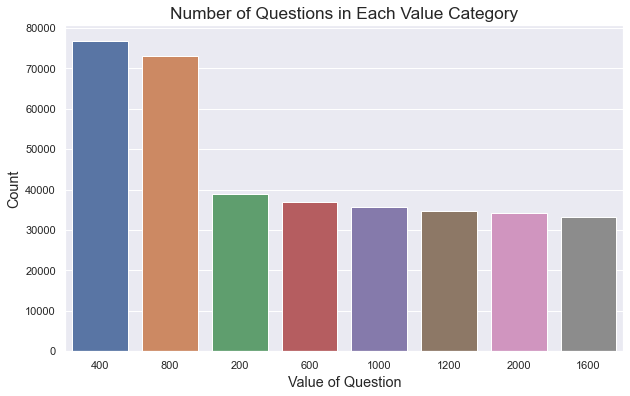

In [26]:
# Visualize the counts of each value category
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=df, 
    x="value",
    order=df.value.value_counts().index)

ax.set_title('Number of Questions in Each Value Category',fontsize='x-large')
ax.set_xlabel('Value of Question',fontsize='large')
ax.set_ylabel('Count',fontsize='large')

plt.show();

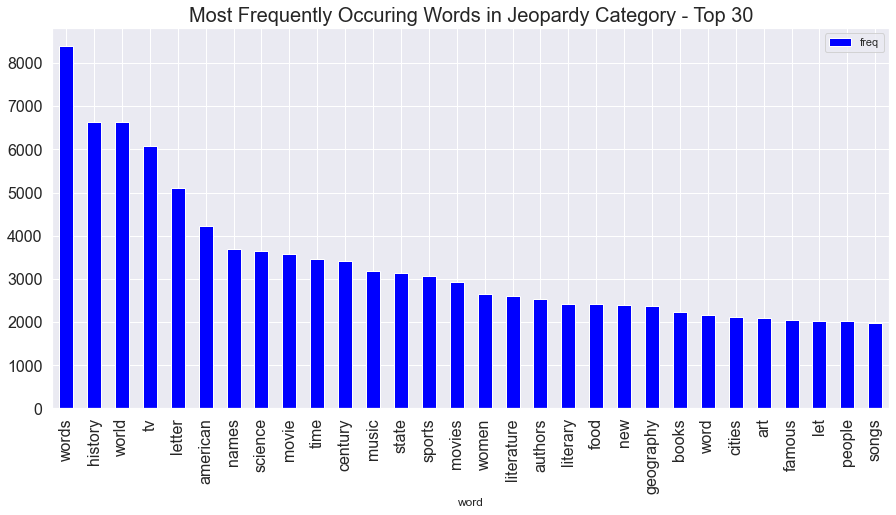

In [27]:
#graph frequency of top 30 words in 'category'

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.category)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title('Most Frequently Occuring Words in Jeopardy Category - Top 30', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

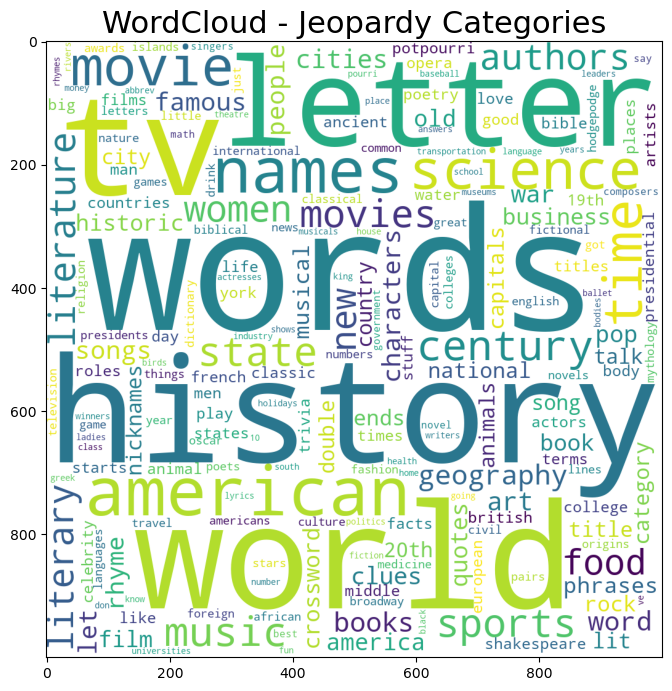

In [28]:
# A word cloud of Jeopardy categories

from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
sns.reset_defaults() 
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title('WordCloud - Jeopardy Categories', fontsize = 22);

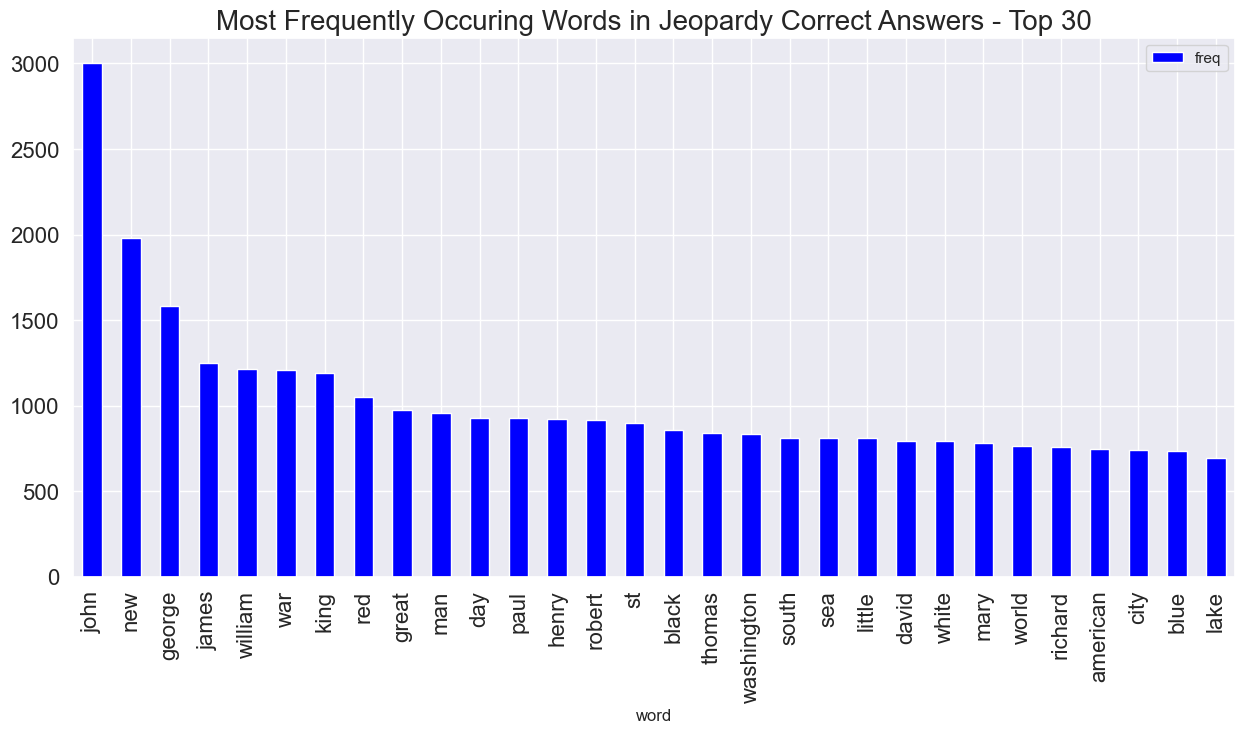

In [32]:
#graph frequency of top 30 words in the correct answers

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.question)
sns.set_theme(style="darkgrid")
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title('Most Frequently Occuring Words in Jeopardy Correct Answers - Top 30', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

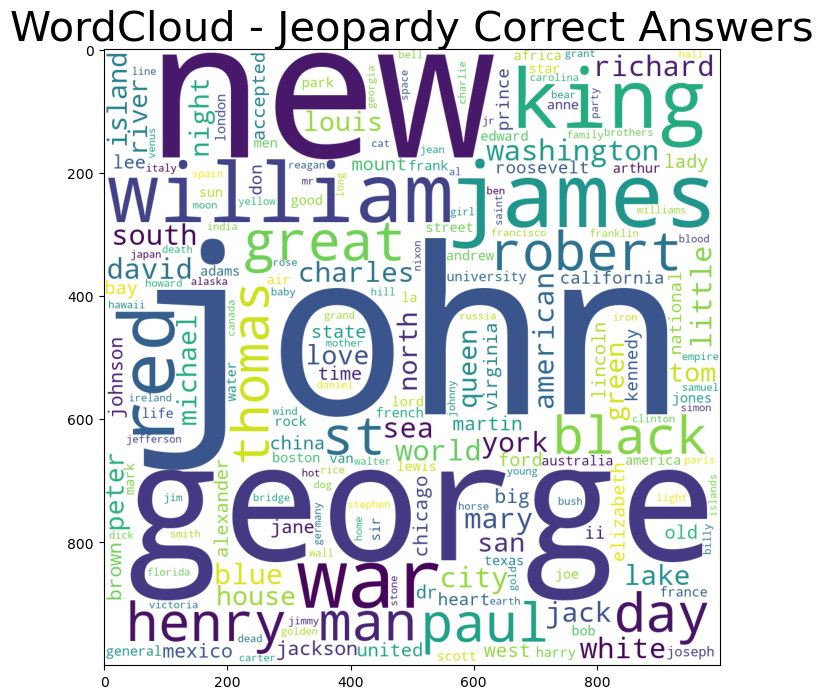

In [33]:
# A word cloud of Jeopardy Correct Answers

from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
sns.reset_defaults() 
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title('WordCloud - Jeopardy Correct Answers', fontsize = 30)
plt.savefig('answer_wordcloud.png');

## NLP Data Cleaning

In [31]:
# import string to remove punctuation

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def no_punctuation(text):
    nopunct=[words for words in text if words not in string.punctuation]
    words_without_punct=''.join(nopunct)
    return words_without_punct

In [15]:
#remove punctuation and lowercase words in 'category,' 'answer,' and 'question'

df['category'] = df['category'].apply(lambda x: no_punctuation(x).lower())
df['answer'] = df['answer'].apply(lambda x: no_punctuation(x).lower())
df['question'] = df['question'].apply(lambda x: no_punctuation(x).lower())

In [15]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-
3,1,800,no,lakes rivers,-,american river only 33 miles shorter than the ...,the missouri,1984-09-10,-
4,1,1000,no,lakes rivers,-,worlds largest lake nearly 5 times as big as s...,the caspian sea,1984-09-10,-
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-
389441,2,800,no,foundry,-,around 4000 years ago the first foundries in m...,bronze,2021-08-13,-
389442,2,1200,no,foundry,-,several different foundries worked for 4 month...,monitor,2021-08-13,-


In [16]:
#remove numerals from 'category,' 'answer,' and 'question'

df['category'] = df['category'].str.replace('\d+', '')
df['answer'] = df['answer'].str.replace('\d+', '')
df['question'] = df['question'].str.replace('\d+', '')

In [38]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-


## Modeling

In [17]:
#Use 'answer' (Jeopardy questions) as the feature and 'value' as the target

X = df['answer']
y = df['value']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=54)

### Linear Regression Models

In [22]:
# Instantiate the vectorizer

tfidf = TfidfVectorizer()

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

In [54]:
X_train_vectorized.shape

(272823, 114527)

In [60]:
baseline_regression_model = LinearRegression()
baseline_regression_cv = cross_val_score(baseline_regression_model, X_train_vectorized, y_train, scoring='neg_root_mean_squared_error')
baseline_regression_cv

array([-635.20388844, -642.74965928, -638.02925061, -642.8727137 ,
       -638.54930596])

In [62]:
#Average of cross-validated scores
print("Regression Baseline:", -(baseline_regression_cv.mean()))

Regression Baseline: 639.4809635967189


#### Tweak TfidVectorizer

In [63]:
#run again with stop words removed
tfidf_stopwords = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on X_train and transform it
X_train_vectorized_stopwords = tfidf_stopwords.fit_transform(X_train)

In [64]:
stopwords_regression_model = LinearRegression()
stopwords_regression_cv = cross_val_score(stopwords_regression_model, X_train_vectorized_stopwords, y_train, scoring='neg_root_mean_squared_error')
stopwords_regression_cv

array([-633.5143997 , -641.85094832, -636.60297825, -641.09981544,
       -637.323696  ])

In [65]:
#Average of cross-validated scores
print("Regression Baseline:", -(baseline_regression_cv.mean()))
print("Stopwords Removed:", -(stopwords_regression_cv.mean()))

Regression Baseline: 639.4809635967189
Stopwords Removed: 638.0783675407154


Slight improvement with stopwords removed

In [66]:
#run again with stopwords removed and bigrams in addition to unigrams
tfidf_stopwords_bigrams = TfidfVectorizer(stop_words='english', ngram_range= (1, 2))

# Fit the vectorizer on X_train and transform it
X_train_vectorized_stopwords_bigrams = tfidf_stopwords_bigrams.fit_transform(X_train)

In [68]:
stopwords_bigrams_regression_model = LinearRegression()
stopwords_bigrams_regression_cv = cross_val_score(stopwords_bigrams_regression_model, X_train_vectorized_stopwords_bigrams, y_train, scoring='neg_root_mean_squared_error')
stopwords_bigrams_regression_cv

array([-553.67946149, -554.45955038, -553.46610467, -555.00603562,
       -555.39155834])

In [70]:
#Average of cross-validated scores
print("Regression Baseline:", -(baseline_regression_cv.mean()))
print("Stopwords Removed:", -(stopwords_regression_cv.mean()))
print("Stopwords Removed, Add Bigrams:", -(stopwords_bigrams_regression_cv.mean()))

Regression Baseline: 639.4809635967189
Stopwords Removed: 638.0783675407154
Stopwords Removed, Add Bigrams: 554.4005421001089


Adding bigrams significantly improved the model

In [24]:
#run again with stopwords removed and trigram in addition to bigrams & unigrams
tfidf_stopwords_trigrams = TfidfVectorizer(stop_words='english', ngram_range= (1, 3))

# Fit the vectorizer on X_train and transform it
X_train_vectorized_stopwords_trigrams = tfidf_stopwords_trigrams.fit_transform(X_train)

In [52]:
X_train_vectorized_stopwords_trigrams.shape

(272823, 2784210)

In [26]:
stopwords_trigrams_regression_model = LinearRegression()
stopwords_trigrams_regression_cv = cross_val_score(stopwords_trigrams_regression_model, X_train_vectorized_stopwords_trigrams, y_train, scoring='neg_root_mean_squared_error')
stopwords_trigrams_regression_cv

array([-534.08099651, -535.94419871, -533.96256286, -536.56266901,
       -536.00188928])

In [101]:
#Average of cross-validated scores
print("Regression Baseline:", -(baseline_regression_cv.mean()))
print("Stopwords Removed:", -(stopwords_regression_cv.mean()))
print("Stopwords Removed, Add Bigrams:", -(stopwords_bigrams_regression_cv.mean()))
print("Stopwords Removed, Add Trigrams:", -(stopwords_trigrams_regression_cv.mean()))

Regression Baseline: 639.4809635967189
Stopwords Removed: 638.0783675407154
Stopwords Removed, Add Bigrams: 554.4005421001089
Stopwords Removed, Add Trigrams: 535.3104632761718


Trigrams helped a bit more

In [79]:
#run again with stemmed words
#first create a new column of tokenized words, then a column of stemmed words for the 'answer' category
snowBallStemmer = SnowballStemmer("english")
df['tokenized_answer'] = df['answer'].apply(word_tokenize) 
df['stemmed_answer'] = df['tokenized_answer'].apply(lambda row:[snowBallStemmer.stem(word) for word in row])

In [84]:
#change the column so it's not a list of lists
df['stemmed_answer'] = df['stemmed_answer'].str.join(" ")

In [85]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes,stemmed_answer,tokenized_answer
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-,river mention most often in the bibl,"[river, mentioned, most, often, in, the, bible]"
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-,scottish word for lake,"[scottish, word, for, lake]"
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-,american river onli mile shorter than the miss...,"[american, river, only, miles, shorter, than, ..."
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-,world largest lake near time as big as superior,"[worlds, largest, lake, nearly, times, as, big..."
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-,marconi wonder wireless,"[marconis, wonderful, wireless]"
...,...,...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-,in a moveabl feast gertrud stein is quot as ca...,"[in, a, moveable, feast, gertrude, stein, is, ..."
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-,this hefti noisemak from whitechapel foundri b...,"[this, hefty, noisemaker, from, whitechapel, f..."
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-,around year ago the first foundri in mesopotam...,"[around, years, ago, the, first, foundries, in..."
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-,sever differ foundri work for month to build t...,"[several, different, foundries, worked, for, m..."


In [86]:
#change the feature to the stemmed answers
X_stemmed = df['stemmed_answer']
X_stemmed_train, X_stemmed_test, y_train, y_test = train_test_split(X_stemmed, y, test_size= 0.25, random_state=54)

In [105]:
# Fit the vectorizer on X_train and transform it
X_stemmed_train_vectorized_stopwords_trigrams = tfidf_stopwords_trigrams.fit_transform(X_stemmed_train)

In [106]:
stemmed_regression_model = LinearRegression()
stemmed_regression_cv = cross_val_score(stemmed_regression_model, X_stemmed_train_vectorized_stopwords_trigrams, y_train, scoring='neg_root_mean_squared_error')
stemmed_regression_cv

array([-535.66111286, -536.82546188, -535.56122773, -538.29071016,
       -536.82725333])

In [107]:
#Average of cross-validated scores
print("Regression Baseline:", -(baseline_regression_cv.mean()))
print("Stopwords Removed:", -(stopwords_regression_cv.mean()))
print("Stopwords Removed, Add Bigrams:", -(stopwords_bigrams_regression_cv.mean()))
print("Stopwords Removed, Add Trigrams:", -(stopwords_trigrams_regression_cv.mean()))
print("Stopwords Removed, Add Trigrams, Stemmed Words:", -(stemmed_regression_cv.mean())) 

Regression Baseline: 639.4809635967189
Stopwords Removed: 638.0783675407154
Stopwords Removed, Add Bigrams: 554.4005421001089
Stopwords Removed, Add Trigrams: 535.3104632761718
Stopwords Removed, Add Bigrams, Stemmed Words: 536.6331531907838


In [91]:
#run again with lemmatized words
#first create a new column of lemmatized words from the tokenized 'answer' category
lemmatizer = WordNetLemmatizer()
df['lemmatized_answer'] = df['tokenized_answer'].apply(lambda row:[lemmatizer.lemmatize(word) for word in row])

In [92]:
#change the column so it's not a list of lists
df['lemmatized_answer'] = df['lemmatized_answer'].str.join(" ")

In [93]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes,stemmed_answer,tokenized_answer,lemmatized_answer
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-,river mention most often in the bibl,"[river, mentioned, most, often, in, the, bible]",river mentioned most often in the bible
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-,scottish word for lake,"[scottish, word, for, lake]",scottish word for lake
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-,american river onli mile shorter than the miss...,"[american, river, only, miles, shorter, than, ...",american river only mile shorter than the miss...
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-,world largest lake near time as big as superior,"[worlds, largest, lake, nearly, times, as, big...",world largest lake nearly time a big a superior
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-,marconi wonder wireless,"[marconis, wonderful, wireless]",marconi wonderful wireless
...,...,...,...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-,in a moveabl feast gertrud stein is quot as ca...,"[in, a, moveable, feast, gertrude, stein, is, ...",in a moveable feast gertrude stein is quoted a...
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-,this hefti noisemak from whitechapel foundri b...,"[this, hefty, noisemaker, from, whitechapel, f...",this hefty noisemaker from whitechapel foundry...
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-,around year ago the first foundri in mesopotam...,"[around, years, ago, the, first, foundries, in...",around year ago the first foundry in mesopotam...
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-,sever differ foundri work for month to build t...,"[several, different, foundries, worked, for, m...",several different foundry worked for month to ...


In [94]:
#change the feature to the lemmatized answers
X_lemmatized = df['lemmatized_answer']
X_lemmatized_train, X_lemmatized_test, y_train, y_test = train_test_split(X_lemmatized, y, test_size= 0.25, random_state=54)

In [108]:
# Fit the vectorizer on X_train and transform it
X_lemmatized_train_vectorized_stopwords_trigrams = tfidf_stopwords_trigrams.fit_transform(X_lemmatized_train)

In [109]:
lemmatized_regression_model = LinearRegression()
lemmatized_regression_cv = cross_val_score(lemmatized_regression_model, X_stemmed_train_vectorized_stopwords_trigrams, y_train, scoring='neg_root_mean_squared_error')
lemmatized_regression_cv

array([-535.66111286, -536.82546188, -535.56122773, -538.29071016,
       -536.82725333])

In [110]:
#Average of cross-validated scores
print("Regression Baseline:", -(baseline_regression_cv.mean()))
print("Stopwords Removed:", -(stopwords_regression_cv.mean()))
print("Stopwords Removed, Add Bigrams:", -(stopwords_bigrams_regression_cv.mean()))
print("Stopwords Removed, Add Trigrams:", -(stopwords_trigrams_regression_cv.mean()))
print("Stopwords Removed, Add Trigrams, Stemmed Words:", -(stemmed_regression_cv.mean()))
print("Stopwords Removed, Add Trigrams, Lemmatized Words:", -(lemmatized_regression_cv.mean())) 

Regression Baseline: 639.4809635967189
Stopwords Removed: 638.0783675407154
Stopwords Removed, Add Bigrams: 554.4005421001089
Stopwords Removed, Add Trigrams: 535.3104632761718
Stopwords Removed, Add Trigrams, Stemmed Words: 536.6331531907838
Stopwords Removed, Add Trigrams, Lemmatized Words: 536.6331531907838


Stemming and lemmatizing didn't appear to help the model

In [29]:
#try CountVectorizer instead of Tfidf
count_vec = CountVectorizer(stop_words='english', ngram_range= (1, 3))

# Fit the vectorizer on X_train and transform it
X_train_count_vectorized = count_vec.fit_transform(X_train)

In [30]:
count_vec_regression_model = LinearRegression()
count_vec_regression_cv = cross_val_score(count_vec_regression_model, X_train_count_vectorized, y_train, scoring='neg_root_mean_squared_error')
count_vec_regression_cv

array([-689.88597834, -697.82833682, -698.64316279, -691.36286805,
       -706.15174106])

In [31]:
print("Stopwords Removed, Add Trigrams:", -(stopwords_trigrams_regression_cv.mean()))
print("Count Vectorizer, Stopwords Removed, Add Trigrams:", -(count_vec_regression_cv.mean()))

Stopwords Removed, Add Trigrams: 535.3104632761718
Count Vectorizer, Stopwords Removed, Add Trigrams: 696.7744174117843


Count Vectorizer performed much worse than the Tfidf Vectorizer

In [20]:
#try Hashing Vectorizer instead of Tfidf
hashing_vec = HashingVectorizer(stop_words='english', ngram_range= (1, 3))

# Fit the vectorizer on X_train and transform it
X_train_hashing_vectorized = hashing_vec.fit_transform(X_train)

In [21]:
hashing_vec_regression_model = LinearRegression()
hashing_vec_regression_cv = cross_val_score(hashing_vec_regression_model, X_train_hashing_vectorized, y_train, scoring='neg_root_mean_squared_error')
hashing_vec_regression_cv

array([-610.19417938, -610.54330032, -610.68291132, -610.91044049,
       -611.05749954])

In [47]:
hashing_vec_regression_cv_model = 'hashing_vec_regression_cv.sav'
joblib.dump(hashing_vec_regression_cv, hashing_vec_regression_cv_model)

['hashing_vec_regression_cv.sav']

In [32]:
print("Stopwords Removed, Add Trigrams:", -(stopwords_trigrams_regression_cv.mean()))
print("Count Vectorizer, Stopwords Removed, Add Trigrams:", -(count_vec_regression_cv.mean()))
print("Hashing Vectorizer, Stopwords Removed, Add Trigrams:", -(hashing_vec_regression_cv.mean()))

Stopwords Removed, Add Trigrams: 535.3104632761718
Count Vectorizer, Stopwords Removed, Add Trigrams: 696.7744174117843
Hashing Vectorizer, Stopwords Removed, Add Trigrams: 610.6776662106893
